# 1. 환경 설정

## 1-1. 라이브러리

In [ ]:
# 필요한 라이브러리 로드
import tensorflow as tf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import gc
import os
import random
import re
from sklearn.metrics import *
import warnings
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

warnings.filterwarnings(action='ignore')

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

## 1-2. 데이터셋 로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # 구글 드라이브를 사용하는 경우

train_df = pd.read_csv("/content/drive/MyDrive/dacon/unsupervised_card/data/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/dacon/unsupervised_card/data/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/dacon/unsupervised_card/data/test.csv") 

print("================데이터셋 크기================")
print(train_df.shape) # 569 샘플, 32 컬럼으로 구성된 데이터
print("================데이터셋 구조================")
print(train_df.info())
print("================데이터셋 샘플================")
train_df.head() # 데이터 샘플

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
================데이터셋 크기================
(113842, 31)
================데이터셋 구조================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113842 entries, 0 to 113841
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      113842 non-null  int64  
 1   V1      113842 non-null  float64
 2   V2      113842 non-null  float64
 3   V3      113842 non-null  float64
 4   V4      113842 non-null  float64
 5   V5      113842 non-null  float64
 6   V6      113842 non-null  float64
 7   V7      113842 non-null  float64
 8   V8      113842 non-null  float64
 9   V9      113842 non-null  float64
 10  V10     113842 non-null  float64
 11  V11     113842 non-null  float64
 12  V12     113842 non-null  float64
 13  V13     113842 non-null  float64
 14  V14     113842 non-null  float64
 15  V15     113842 n

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


In [ ]:
frauds = val_df[val_df.Class == 1]
normal = val_df[val_df.Class == 0]
frauds.shape

(30, 32)

In [ ]:
normal.shape

(28432, 32)

## 1-3. 데이터셋 지정
- val 데이터 사용 시만 실행

In [ ]:
# train_df = val_df.copy()
# val_y = train_df['Class']
# train_df = train_df.drop(columns=['Class'])

# 2. 데이터 전처리

In [ ]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


In [ ]:
# Train dataset은 Label이 존재하지 않음
train_x = train_df.drop(columns=['ID']) # Input Data
# Validation 사용 테스트
# train_x = val_df.drop(columns=['ID']) # Input Data

In [ ]:
train_x.shape

(113842, 30)

In [ ]:
# col = train_x.columns.drop('Class')
col = train_x.columns

for i in col:
    sc=StandardScaler()
    train_x[i]=sc.fit_transform(train_x[i].values.reshape(-1,1))

In [ ]:
X_train, X_test = train_test_split(train_x, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
# X_train = X_train.drop(['Class'], axis=1)

# y_test = X_test['Class']
# X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(91073, 30)

In [ ]:
X_test.shape

(22769, 30)

# 3. 모델링

## 3-1. Auto Encoder

In [ ]:
def make_model(X_train):

    input_dim = X_train.shape[1]
    encoding_dim = 32

    input_layer = Input(shape=(input_dim, ))

    encoder = Dense(encoding_dim, activation="leaky_relu", 
                    activity_regularizer=regularizers.l1(10e-5))(input_layer)
                    
    encoder = layers.Dropout(0.1)(encoder)
    encoder = Dense(int(encoding_dim * 2), activation="leaky_relu")(encoder)
    encoder = layers.Dropout(0.1)(encoder)
    decoder = Dense(int(encoding_dim / 2), activation='leaky_relu')(encoder)
    decoder = layers.Dropout(0.1)(decoder)
    decoder = Dense(input_dim, activation='leaky_relu')(decoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    
    return autoencoder

In [ ]:
def model_run(model, x_train, x_val, checkpoint_path, optimizer="adam"):
  epochs = 500
  batch_size = 32

  callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path, save_weights_only=True, verbose=1, save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001, mode='min'
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),
  ]
  model.compile(
    optimizer=optimizer,
    loss="mean_squared_error",
    metrics=["accuracy"],
  )
  history = model.fit(
    x_train,
    x_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data = (x_val, x_val), 
    # validation_split=0.2,
    verbose=1,
  )

  return history

In [ ]:
# 모델 저장 경로

model_dir = "/content/drive/MyDrive/dacon/unsupervised_card/220725_AE/"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# 체크포인트 파일 저장 경로
checkpoint_path = model_dir+"checkpoints_model_ae.ckpt"

In [ ]:
autoencoder = make_model(X_train)
print(autoencoder.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_16 (Dense)            (None, 32)                992       
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 64)                2112      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 16)                1040      
                                                                 
 dropout_11 (Dropout)        (None, 16)                0   

## 3-2. 모델 학습

In [ ]:
history = model_run(autoencoder, X_train, X_test, checkpoint_path, optimizer="adam")

Epoch 1/500
2847/2847 [==============================] - ETA: 0s - loss: 0.6815 - accuracy: 0.3588
Epoch 1: val_loss improved from inf to 0.54964, saving model to /content/drive/MyDrive/dacon/unsupervised_card/220720_AE/checkpoints_model_ae.ckpt
2847/2847 [==============================] - 11s 4ms/step - loss: 0.6815 - accuracy: 0.3588 - val_loss: 0.5496 - val_accuracy: 0.5092 - lr: 0.0010
Epoch 2/500
2830/2847 [============================>.] - ETA: 0s - loss: 0.5759 - accuracy: 0.4300
Epoch 2: val_loss improved from 0.54964 to 0.50668, saving model to /content/drive/MyDrive/dacon/unsupervised_card/220720_AE/checkpoints_model_ae.ckpt
2847/2847 [==============================] - 10s 3ms/step - loss: 0.5775 - accuracy: 0.4301 - val_loss: 0.5067 - val_accuracy: 0.5414 - lr: 0.0010
Epoch 3/500
2846/2847 [============================>.] - ETA: 0s - loss: 0.5461 - accuracy: 0.4487
Epoch 3: val_loss improved from 0.50668 to 0.47598, saving model to /content/drive/MyDrive/dacon/unsupervised_c

# 4. 성능평가

In [ ]:
autoencoder = make_model(X_train)
autoencoder.load_weights(checkpoint_path)
autoencoder.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["accuracy"],
)

In [ ]:
# col = train_x.columns.drop('Class')
col = train_x.columns

for i in col:
    sc=StandardScaler()
    val_df[i]=sc.fit_transform(val_df[i].values.reshape(-1,1))

In [ ]:
X_val = val_df.drop(['ID', 'Class'], axis=1).values
y_val = val_df['Class']

In [ ]:
predictions = autoencoder.predict(X_val)
mse = np.mean(np.power(X_val - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_val})
error_df.describe()

,reconstruction_error,true_class
count,28462.000000,28462.000000
mean,0.355724,0.001054
std,1.276637,0.032449
min,0.023659,0.000000
25%,0.135822,0.000000
50%,0.208111,0.000000
75%,0.328650,0.000000
max,66.793141,1.000000


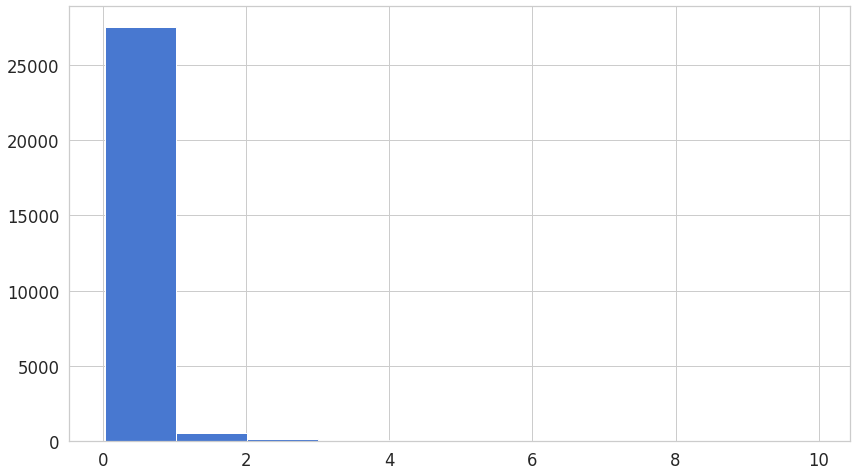

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

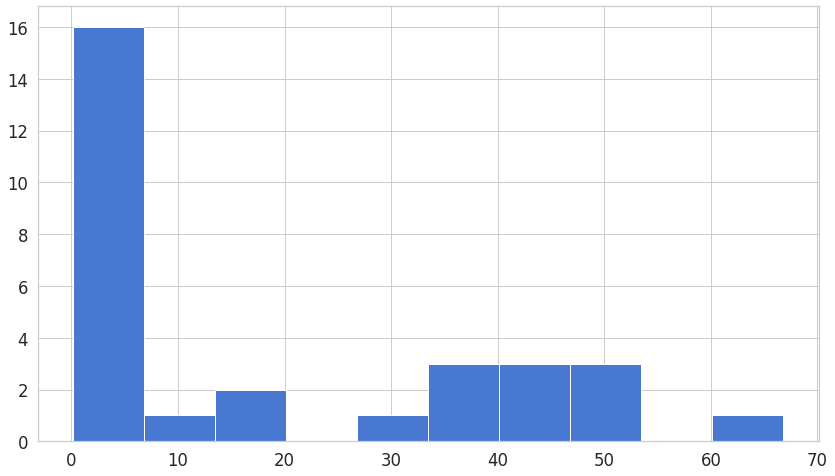

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

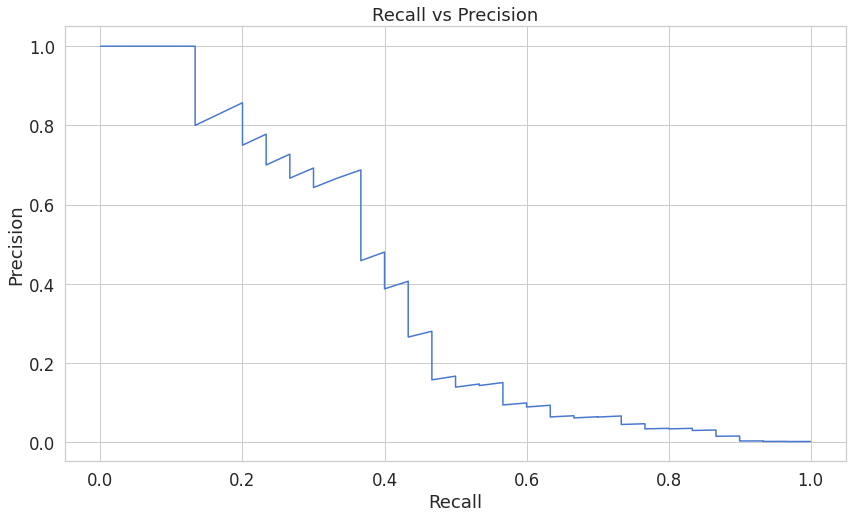

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

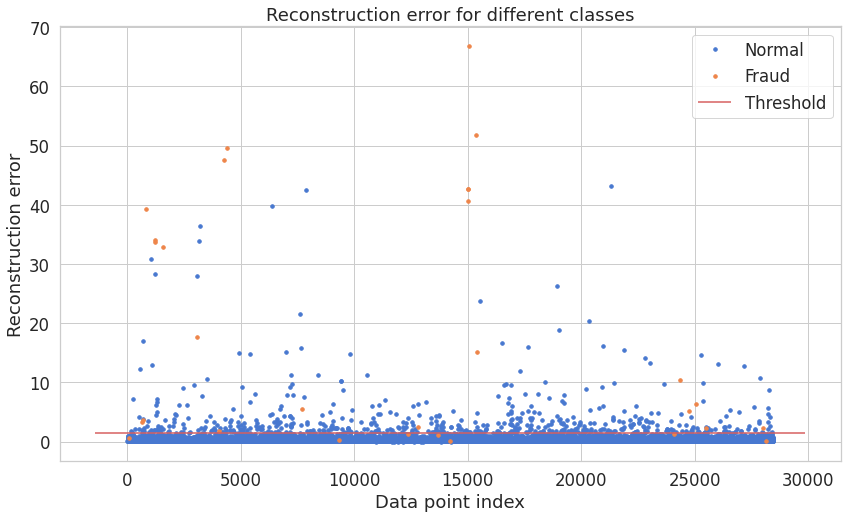

In [ ]:
threshold = 1.5

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

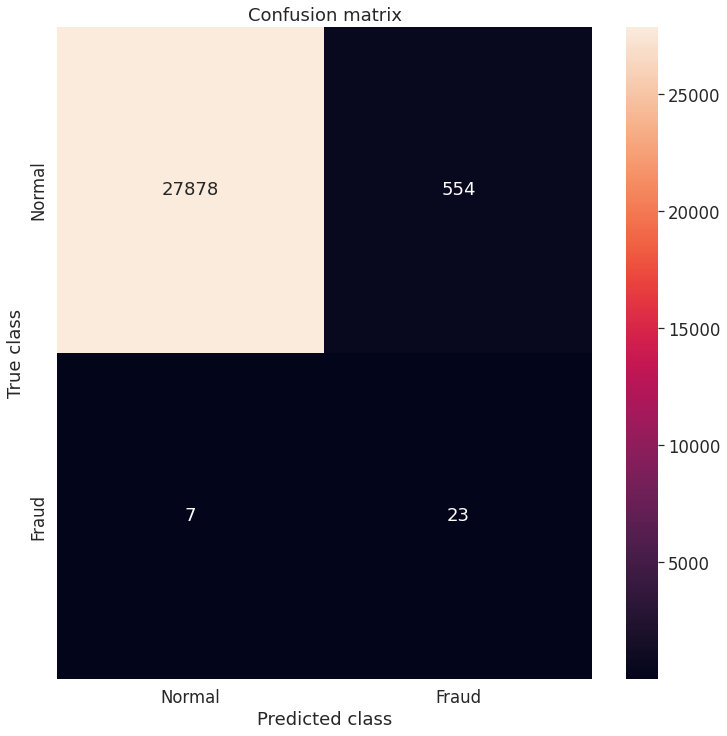

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# 5. 제출 파일 생성

In [ ]:
# col = train_x.columns.drop('Class')
col = train_x.columns

for i in col:
    sc=StandardScaler()
    test_df[i]=sc.fit_transform(test_df[i].values.reshape(-1,1))

In [ ]:
test_x = test_df.drop(columns=['ID'])
X_test = test_x.values

In [ ]:
predictions = autoencoder.predict(X_test) # model prediction
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

threshold = 1.5
test_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon/unsupervised_card/data/sample_submission.csv')
submit.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [ ]:
submit['Class'] = test_pred
submit.to_csv('/content/drive/MyDrive/dacon/unsupervised_card/submit_auto_encoder_220725.csv', index=False)

In [ ]:
submit['Class'].value_counts()

0    139731
1      2772
Name: Class, dtype: int64